## <center>Probabilistic Programming Workflow</center>

### <center>Open Source Tools for Rapid Reproducible Bayesian Model Development</center>

<a id='TOP'></a>
### Notebook Content:
1. [Overview](#Overview)
    1. [Ensuring Reproducibility](#Reprod)
    2. [PP as modeling framework](#PPOverview)
2. [Loading Field Data](#DataLoad)
3. [Pre-Processing](#DataPrep)
   1. [Data Cleaning](#cleaning)
   2. [Exogenous Feature Extraction](#exo)
       1. [Dealing with time data](#datetime)
       2. [Consolidating fluo/hplc chl](#fluo/hplc)
       2. [Log-transform](#log)
       3. [Green-to-max(Blue) ratio](#green2blue)
       4. [Sub-grouping](#sub)
   4. [Data Splitting into Train/Test Sets](#split)
   5. [Endogenous Data Transformation](#endo)
       1. [Scaling Data](#scale)
   6. [Preserving the preprocessing pipeline](#picklepreprocess)
4. [Bayesian Modelling](#PyMC3)
   1. [Model coding](#writemodel)
   2. [Prior evaluation & Model modification](#priors)
   3. [Model fitting & diagnostics](#fit)
   4. [Model evaluation](#eval)
       1. [Deviance](#deviance)
       2. [Approximation by WAIC](#waic)
5. [Conclusion](Conclusion)

[Back to Contents](#TOP)

## 1. <u>Overview</u>
* Catching up with Probabilistic Programming
* Loading Data -- PanDaS
* Preparing Data -- PanDaS, Seaborn, Scikit-learn
* Rapid Model Development -- PyMC3
* Beyond the Basics

In [1]:
# STL
import os
import pickle
import sys

# numerical libraries
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import __version__ as skver


# graphic facilities
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import __version__ as mpver
import seaborn as sb

In [2]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [3]:
print(f'Matplotlib version..: {mpver}')
print(f'Python version......: {sys.version.split("|")[0]}')
print(f'PanDaS version......: {pd.__version__}')
print(f'Scikit-Learn version: {skver}')
print(f'Seaborn version.....: {sb.__version__}')
print(f'PyMC3 version.......: {pm.__version__}')

Matplotlib version..: 3.0.3
Python version......: 3.7.1 
PanDaS version......: 0.24.1
Scikit-Learn version: 0.20.3
Seaborn version.....: 0.9.0
PyMC3 version.......: 3.6


In [4]:
%matplotlib inline

### Loading and preparing data -- PANDAS
* the nomad dataset
* reading in 
* get column names
* extract desired variables

### Data Exploration -- PANDAS, Seaborn and Scikit-Learn
* predictor isolated distributions
* plotting predictors/predicted w/ respect to each other
* predictor correlation, multicollinearity and pca

### Modeling -- Probabilistic Programming with PyMC3
* simple bayesian regression to predict chlorophyll from Rrs
* rapid but transparent model development
* evaluation of priors
* fitting and evaluation of posterior distribution
* model comparison/selection

[Back to Contents](#TOP)

<a id=DataLoad></a>
## 2. <u>Loading Field Data</u>
<br>
<span style="font-size:16pt">$\ \ \ \Rightarrow$ NOMAD SeaWiFS validation match-up distribution</span><br>
<center><img src='./resources/nomad_seabass_v1_seawifs_map.png?:2' width=900 title="NOMAD SeaWiFS validation match-up distribution"/></center>

<span style="font-size:16pt">$\Rightarrow$   <u>Predictors</u></span>
* sat_rrs  $\rightarrow$ satellite remote-sensing reflectance (sr-1)
* oisst    $\ \ \rightarrow$ optimal interpolation sea surface temperature ($^\circ$C)
---
<span style="font-size:16pt">$\Rightarrow$   <u>Predicted</u></span>
* chl/chl_a $\rightarrow$ chlorophyll a

<u>Other</u>
* id ~ NOMAD record identifier (unitless)

<span style="font-size:16pt">$\Rightarrow$   <u>File content</u></span>
<br><br>
/fields=year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd<br>
...<br>
_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid<br>
/units=-999<br>
/end_header<br>
1997,10,07,09,41,00,42.51,39.52,4065,19.54,1982,0.401,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...

In [8]:
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            # collect column labels
            col_names = line.strip('/fields=').strip().split(',') 
        if '/end_header' in line:
            # record rows to skip
            rowskips = i+1 # i is 0-indexed
            break

In [9]:
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None,
                 names=col_names, skiprows=rowskips, na_values=-999)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


[Back to Contents](#TOP)

<a id=DataPrep></a>
## 3. <u>Pre-Processing</u>

<a id=cleaning></a>
### A. Developing a Data Cleaning Plan

* Don't drop bad data
* Flag (NaN) and retain for optional imputation

In [11]:
df.head(2)

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.51,39.52,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.29,25.11,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1


In [12]:
df.filter(regex=('(sat_rrs|chl)'), axis=1).describe()

,chl,chl_a,sat_rrs412,sat_rrs443,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670
count,262.000000,33.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,1.527438,1.658129,0.005039,0.005038,0.005050,0.004010,0.003162,0.000501
std,3.600463,3.846960,0.003753,0.002865,0.002460,0.002301,0.002645,0.000706
min,0.030000,0.027000,-0.006620,-0.002560,-0.000680,0.000850,0.001090,-0.000790
25%,0.172525,0.060000,0.002107,0.002780,0.003395,0.002770,0.001708,0.000140
50%,0.381000,0.135000,0.004625,0.005265,0.005040,0.003405,0.002120,0.000230
75%,1.382400,1.761000,0.007120,0.006877,0.006262,0.004370,0.003555,0.000560
max,43.100000,20.602000,0.015460,0.012450,0.018730,0.019950,0.021740,0.005000


$\rightarrow$ consolidate date/time columns<br>
$\rightarrow$ consolidate fluo/hplc chlorophyll columns<br>
$\rightarrow$ deal with negative Rrs values

<a id=datetime></a>
#### a. Dealing with date/time data: 
$\ \ \ \Rightarrow$ Consolidation of multiple date/time columns into single column of datetime objects

In [13]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns],
                                        format='%Y-%m-%d %H:%M:%S'))
df.drop(date_time_columns, axis=1, inplace=True)

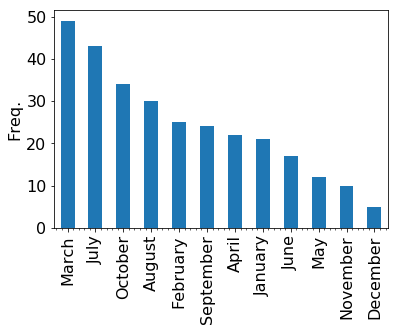

In [14]:
ax = df.datetime.dt.month_name().value_counts().plot(kind='bar')
ax.set_ylabel('Freq.');

<a id=hplcfluo></a>
#### b. Consolidating hplc/fluo chlorophyll data

In [15]:
# two types of chlorophyll a:
df.filter(regex='chl', axis=1).info()
# chl: obtained by fluorometry
# chl_a: obtained by hplc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [16]:
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']

In [17]:
# fill consolidated chlor_a column with chl_a (hplc) when possible, chl (fluo) otherwise
df['chlor_a'] = df.apply(fill_chl, axis=1)

In [18]:
# Flag chlor_a measurement type; hplc/fluo 
df['is_hplc'] = np.isfinite(df.chl_a)

In [19]:
df.filter(regex='chl', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
chl        262 non-null float64
chl_a      33 non-null float64
chlor_a    292 non-null float64
dtypes: float64(3)
memory usage: 6.9 KB


[Back to Contents](#TOP)

#### c. Cleaning Rrs

In [20]:
# assign Nan to nonpositive sat. Rrs
sat_cols = df.filter(regex='sat_rrs', axis=1).columns

In [21]:
for col in sat_cols:
    df.loc[df[col]<=0, col] = np.NaN

[Back to Contents](#TOP)

<a id=exo></a>
### B. Exogenous Feature Transformation

$\ \ \ \Rightarrow$ Transformation that is independent of dataset properties

[Back to Contents](#TOP)

<a id=log></a>
#### a. Log-transform

In [22]:
# Log-transform Rrs Data
for col in sat_cols:
    df[f'log_{col}'] = np.log10(df[col])

In [23]:
# Log-transform Chl Data
df['log_chlor_a'] = np.log10(df.chlor_a)

In [24]:
df.filter(regex='(rrs|chlor_a)', axis=1).head(2)

,sat_rrs412,sat_rrs443,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,chlor_a,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_sat_rrs555,log_sat_rrs670,log_chlor_a
0,0.00239,0.00288,0.00345,0.00297,0.00217,0.00026,0.401,-2.621602,-2.540608,-2.462181,-2.527244,-2.663540,-3.585027,-0.396856
1,0.00572,0.00592,0.00494,0.00348,0.00191,0.00018,0.091,-2.242604,-2.227678,-2.306273,-2.458421,-2.718967,-3.744727,-1.040959


[Back to Contents](#TOP)

#### b. Blue-green ratio

* similar to OC4 variable but inverse
* not polynomial
* takes into account dominant blue band
$$\large{X=log_{10}\left(\frac{Rrs_{555}}{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}\right)}$$

In [31]:
blue_band_cols = ['log_sat_rrs443', 'log_sat_rrs490', 'log_sat_rrs510']
df['log_maxBlue'] = df[blue_band_cols].max(axis=1)

In [32]:
df['green2MaxBlue'] = df.log_sat_rrs555 - df.log_maxBlue

#### e. Sub-grouping

In [33]:
df['maxBlueID'] = df[blue_band_cols].idxmax(axis=1)
df['maxBlueID'] = df.maxBlueID.str.extract('(rrs[0-9]+)').iloc[:, 0].str.capitalize()

In [37]:
maxBlueCat = pd.CategoricalDtype(categories=np.sort(df.maxBlueID.unique()), ordered=True)
df['maxBlueIdx'] = df.maxBlueID.astype(maxBlueCat).cat.codes

In [38]:
df[blue_band_cols + ['log_maxBlue', 'maxBlueID', 'maxBlueIdx', 'green2MaxBlue']].head()

,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_maxBlue,maxBlueID,maxBlueIdx,green2MaxBlue
0,-2.540608,-2.462181,-2.527244,-2.462181,Rrs490,1,-0.201359
1,-2.227678,-2.306273,-2.458421,-2.227678,Rrs443,0,-0.491288
2,-2.073143,-2.204120,-2.425969,-2.073143,Rrs443,0,-0.701547
3,-2.910095,-2.752027,-2.714443,-2.714443,Rrs510,2,0.006699
4,-2.903090,-2.744727,-2.703335,-2.703335,Rrs510,2,0.002188


In [39]:
df.maxBlueID.value_counts(normalize=True)* 100

Rrs443    44.520548
Rrs490    30.479452
Rrs510    25.000000
Name: maxBlueID, dtype: float64

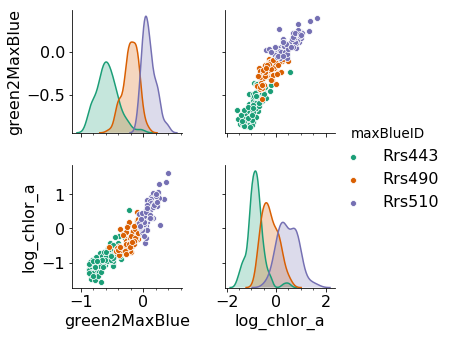

In [41]:
sb.pairplot(df, vars=['green2MaxBlue', 'log_chlor_a'], hue='maxBlueID',
            hue_order=['Rrs443', 'Rrs490', 'Rrs510'], palette='Dark2');
f = pl.gcf()
f.savefig('./resources/pairplot.png', dpi=300)

<center><img src='./resources/pairplot.png?:1'/></center>

[Back to Contents](#TOP)

<a id=split></a>
### C. Splitting Data into Train/Test Sets

#### a. Extract relevant subset

In [43]:
df_extr = df[['datetime', 'green2MaxBlue', 'maxBlueID', 'maxBlueIdx', 'log_chlor_a']]
df_extr.head()

,datetime,green2MaxBlue,maxBlueID,maxBlueIdx,log_chlor_a
0,1997-10-07 09:41:00,-0.201359,Rrs490,1,-0.396856
1,1997-10-11 09:32:00,-0.491288,Rrs443,0,-1.040959
2,1997-09-27 11:29:00,-0.701547,Rrs443,0,-0.801343
3,1998-05-16 08:30:00,0.006699,Rrs510,2,0.420995
4,1998-05-16 09:16:00,0.002188,Rrs510,2,0.401228


[Back to Contents](#TOP)

#### b. Split into train/test sets

In [44]:
X = df_extr.iloc[:, :-1]
y = df_extr.loc[:, ['log_chlor_a']] # extra brackets to retain DataFrame type

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=X.maxBlueID)

In [47]:
X.maxBlueID.value_counts(normalize=True)*100

Rrs443    44.520548
Rrs490    30.479452
Rrs510    25.000000
Name: maxBlueID, dtype: float64

In [48]:
X_train.maxBlueID.value_counts(normalize=True)*100

Rrs443    44.354839
Rrs490    30.645161
Rrs510    25.000000
Name: maxBlueID, dtype: float64

In [49]:
X_train.head(2)

,datetime,green2MaxBlue,maxBlueID,maxBlueIdx
216,1999-01-29 14:33:00,-0.233493,Rrs490,1
242,2000-08-22 14:30:00,0.002292,Rrs510,2


[Back to Contents](#TOP)

<a id=endo> </a>

### D. Endogenous Feature Extraction: Standardization
$\ \ \ \Rightarrow$ Transformation is dependent on data properties

* Most often refers to $$\frac{X - mean(X)}{std(X)}$$
* good modeling practice generally
* helps putting different variables on comparable scale
* helps relate input to output in terms of z-score

[Back to Contents](#TOP)

In [50]:
# Instantiate scaler
sc_X = StandardScaler()
sc_y = StandardScaler()

In [51]:
# don't standardize datetime, maxBlueID, maxBlueIdx columns
X_train_s_array = sc_X.fit_transform(X_train.iloc[:, 1:-2]) 
y_train_s_array = sc_y.fit_transform(y_train)

In [52]:
# make new dataframe with standardized data using same index as before to retain link to original observations
X_train_s = pd.DataFrame(X_train_s_array, index=X_train.index,
                        columns=[f'{col}_s' for col in X_train.iloc[:, 1:-2].columns])
X_train_s = X_train[['datetime', 'maxBlueID', 'maxBlueIdx']].merge(X_train_s, how='outer',
                                                     left_index=True, right_index=True)
y_train_s = pd.DataFrame(y_train_s_array, columns=[f'{col}_s'
                                             for col in y_train.columns],
                         index=y_train.index)

In [53]:
X_train_s.head()

,datetime,maxBlueID,maxBlueIdx,green2MaxBlue_s
216,1999-01-29 14:33:00,Rrs490,1,0.203137
242,2000-08-22 14:30:00,Rrs510,2,0.987330
278,1999-10-25 13:20:00,Rrs510,2,1.670619
141,1999-07-07 14:35:00,Rrs443,0,-1.018703
221,2001-06-04 19:11:00,Rrs490,1,0.065273


In [54]:
y_train_s.head()

,log_chlor_a_s
216,0.831818
242,1.082246
278,2.042186
141,-0.986848
221,-0.200597


In [55]:
X_test_s_array = sc_X.transform(X_test.iloc[:, 1:-2])
y_test_s_array = sc_y.transform(y_test)

In [56]:
# make new dataframe with standardized data using same index as before to retain link to original observations
X_test_s = pd.DataFrame(X_test_s_array, index=X_test.index,
                        columns=[f'{col}_s' for col in X_test.iloc[:, 1:-2].columns])
X_test_s = X_test[['datetime', 'maxBlueID', 'maxBlueIdx']].merge(X_test_s, how='outer',
                                                     left_index=True, right_index=True)
y_test_s = pd.DataFrame(y_test_s_array, columns=[f'{col}_s'
                                             for col in y_test.columns],
                         index=y_test.index)

[Back to Contents](#TOP)

<a id='picklepreprocess'> </a>

### E. Pickling the pipeline

$\ \ \ \Rightarrow$ use python dictionaries for easy reference

In [57]:
train_dict = dict(X=X_train, 
                  X_s=X_train_s,
                  y=y_train, 
                  y_s=y_train_s)

In [58]:
test_dict = dict(X=X_test,
                 X_s=X_test_s,
                 y=y_test,
                 y_s=y_test_s)

In [59]:
transformers_dict = dict(X_scaler=sc_X,
                         y_scaler=sc_y,)

In [60]:
preprocess_dict = dict(raw_data=df,
                       training=train_dict,
                       testing=test_dict,
                       transformers=transformers_dict)

In [61]:
with open('./preprocess_dicts.pkl', 'wb') as fb:
    pickle.dump(preprocess_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
print(f"{os.path.getsize('./preprocess_dicts.pkl')/1000}kB")

443.438kB


[Back to Contents](#TOP)

<a id='PyMC3'></a>
### 4. Bayesian Modeling:

Pooled models:
* Multivariate regression model with Green/max(Blue) as predictor 
* Multivariate regression model with Green/max(Blue) and SST as predictors

Partially pooled models
* Hierarchcal regression model with Green/max(Blue) as predictor and grouping by maxBlueID 
* Hierarchical regression model with Green/max(Blue) and SST as predictors and grouping by maxBlueID

In [128]:
import pickle

import numpy as np
import pandas as pd
import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams

In [129]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [4]:
with open('./preprocess_dicts.pkl', 'rb') as fb:
    preproc_dict = pickle.load(fb)

In [5]:
X_train_s = preproc_dict['training']['X_s']
X_test_s = preproc_dict['testing']['X_s']
y_train_s = preproc_dict['training']['y_s']
y_test_s = preproc_dict['testing']['y_s']

In [6]:
X_train_s.head()

,datetime,maxBlueID,maxBlueIdx,green2MaxBlue_s
216,1999-01-29 14:33:00,Rrs490,1,0.203137
242,2000-08-22 14:30:00,Rrs510,2,0.987330
278,1999-10-25 13:20:00,Rrs510,2,1.670619
141,1999-07-07 14:35:00,Rrs443,0,-1.018703
221,2001-06-04 19:11:00,Rrs490,1,0.065273


In [98]:
with pm.Model() as m_pooled_naive:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 5) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + X_train_s.green2MaxBlue_s.values * β # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

In [99]:
m_pooled_naive_graph = pm.model_to_graphviz(m_pooled_naive)
m_pooled_naive.format='png'
m_pooled_naive_graph.render(filename='m_pooled_naive_graph', directory='./resources/', view=False);

<center><img src='./resources/m_pooled_naive_graph.png?:0' width=700 /></center>

[Back to Contents](#TOP)

<a id='priors'></a>
#### b. Prior predictive simulation

In [113]:
def eval_priors(model, y_, fpath, ylim=(-5, 5)):
    # Sample parameters and simulate predictor from model priors
    # Sample parameters
    priors = pm.sample_prior_predictive(model=model, vars=['α', 'β', 'log_chl_s'])
    β_prior = priors['β'].reshape(-1, 1)
    α_prior = priors['α'].reshape(-1, 1)
    log_chl_prior = priors['log_chl_s']
    
    # Create dummy variable
    x_dummy = np.linspace(-3., 3., num=50).reshape(1, -1)
    # Simulate log chl from model priors
    log_chl_lines = α_prior + β_prior * x_dummy
    f, ax = pl.subplots(ncols=2, figsize=(12, 4))
    for i in range(500):
        ax[0].plot(x_dummy.T, log_chl_lines[i], alpha=0.03, color='k')
    ax[0].set_ylim(ylim);
    ax[0]. set_xlabel(r'$\frac{Rrs_{555}}{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}$, standardized')
    ax[0].set_ylabel(r'$log_{10}(chl)$, standardized')
    ax[1].hist(priors['log_chl_s'].flatten(), density=True, alpha=0.3, bins=100,
               orientation='horizontal', label='prior');
    ax[1].set_ylim(ylim)
    ax[1].set_xticklabels([])
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position("right")
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel(r'$log_{10}(chl)$, standardized')
    ax[1].set_xlabel(r'$Freq.$')
    ax2 = ax[1].twiny()
    ax2.hist(y_.values, color='k', density=True, alpha=0.5, bins=20,
             orientation='horizontal', label='observed');
    ax2.set_xticklabels([])
    ax2.legend(loc='lower right')
    f.tight_layout()
    f.savefig(fpath, dpi=300)

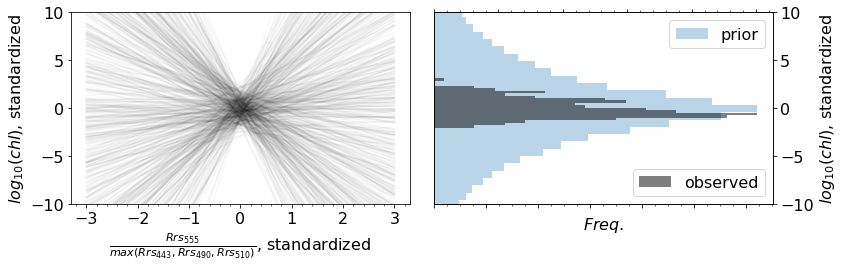

In [114]:
eval_priors(m_pooled_naive, y_=y_train_s.log_chlor_a_s, 
            fpath='./resources/priors_predictive_pooled_naive.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pooled_naive.png?:0'/></center>

$\Rightarrow$ Nonsensical log(chl) values $\rightarrow$ Priors too naive; need adjustment<br>
$\Rightarrow$ Informative priors $\rightarrow$ Incorportation of background knowledge into model

In [117]:
with pm.Model() as m_pooled_wk_informative:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 1) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + X_train_s.green2MaxBlue_s.values * β # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

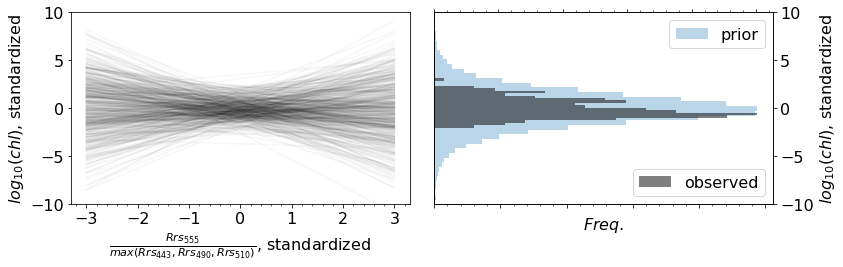

In [118]:
eval_priors(m_pooled_wk_informative, y_=y_train_s.log_chlor_a_s,
            fpath='./resources/priors_predictive_pooled_wk_informative.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pooled_wk_informative.png?:2'></center>

In [119]:
with pm.Model() as m_pooled_informative:
    α = pm.Normal('α', 0, 0.5) # prior on intercept
    β = pm.Normal('β', 0, 0.2) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + β * X_train_s.green2MaxBlue_s.values # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

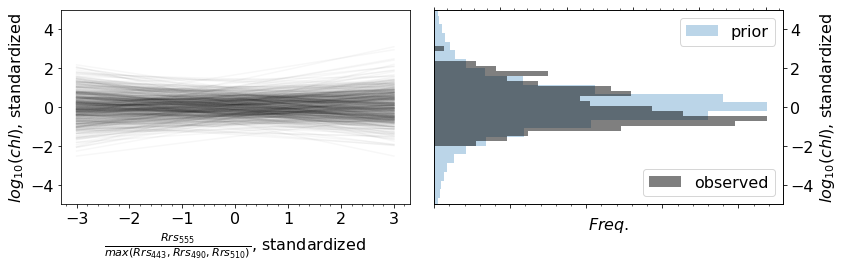

In [120]:
eval_priors(m_pooled_informative, y_=y_train_s.log_chlor_a_s,
            fpath='./resources/priors_predictive_pooled_informative.png', ylim=(-5, 5))

<center><img src='./resources/priors_predictive_pooled_informative.png?:3'/></center>

In [121]:
with m_pooled_naive:
    trace_pooled_naive = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1276.61draws/s]


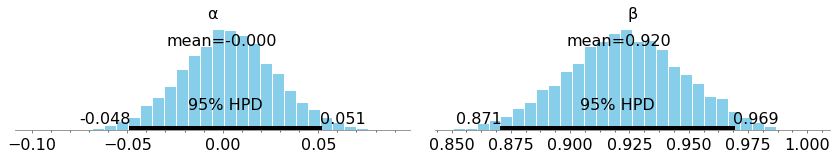

In [122]:
pm.plot_posterior(trace=trace_pooled_naive, varnames=['α', 'β']);

In [123]:
with m_pooled_wk_informative:
    trace_pooled_wk_informative = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1337.94draws/s]


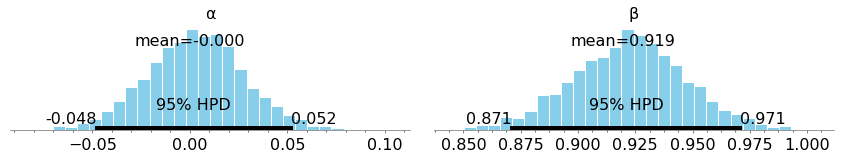

In [124]:
pm.plot_posterior(trace=trace_pooled_wk_informative, varnames=['α', 'β']);

In [125]:
with m_pooled_informative:
    trace_pooled_informative = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1325.94draws/s]


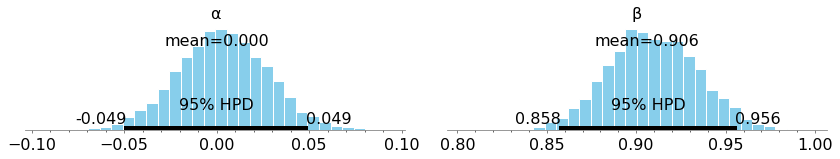

In [126]:
pm.plot_posterior(trace=trace_pooled_informative, varnames=['α', 'β']);

In [130]:
ppc = pm.sample_posterior_predictive(trace_pooled_informative,
                                     model=m_pooled_informative)['log_chl_s']
ppc_mean = ppc.mean(axis=0)
hpd = pm.hpd(ppc)

100%|██████████| 4000/4000 [00:03<00:00, 1139.48it/s]


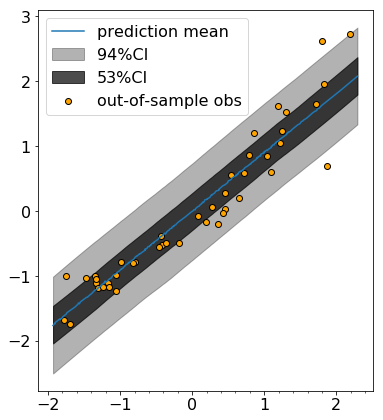

In [135]:
x_idx = X_train_s.green2MaxBlue_s.argsort()

f, ax = pl.subplots(figsize=(6, 7))
ax.plot(X_train_s.green2MaxBlue_s.values[x_idx],ppc_mean[x_idx], label='prediction mean')
ar.plot_hpd(X_train_s.green2MaxBlue_s, ppc, fill_kwargs=dict(alpha=0.3, color='k', 
                                                    label='94%CI'),
            credible_interval=0.94, ax=ax)
ar.plot_hpd(X_train_s.green2MaxBlue_s, ppc, fill_kwargs=dict(alpha=0.7, color='k',
                                                    label='53%CI'),
            credible_interval=0.53, ax=ax)
ax.scatter(X_test_s.green2MaxBlue_s.values, y_test_s, color='orange', edgecolor='k',
           label='out-of-sample obs')
ax.legend(loc='upper left')
f.savefig('./resources/ppc_informative.png', dpi=300)

<center><img src="./resources/ppc_informative.png?:1"  width=600 /></center>

### TODO develop unpooled and hierarchical partially pooled models

In [140]:
n_blue_groups = X_train_s.maxBlueIdx.unique().size
with pm.Model() as m_unpooled_informative:
    # prior on intercept
    α = pm.Normal('α', 0, 0.5, shape=n_blue_groups) 
    # prior on slopes
    β = pm.Normal('β', 0, 0.2, shape=n_blue_groups) 
    # prior on likelihood variance
    σ = pm.Exponential('σ', 1) 
    # likelihood's mean deterministic expression
    μ = α[X_train_s.maxBlueIdx.values,] + β[X_train_s.maxBlueIdx,] * X_train_s.green2MaxBlue_s.values 
    # likelihood
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) 

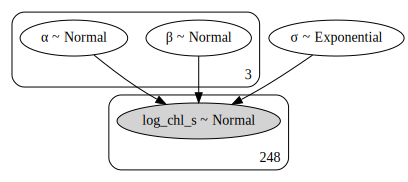

In [142]:
with m_unpooled_informative:
    trace_unpooled_informative = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/madhatter106/anaconda3/envs/busan_2019/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:16<00:00, 360.67draws/s]


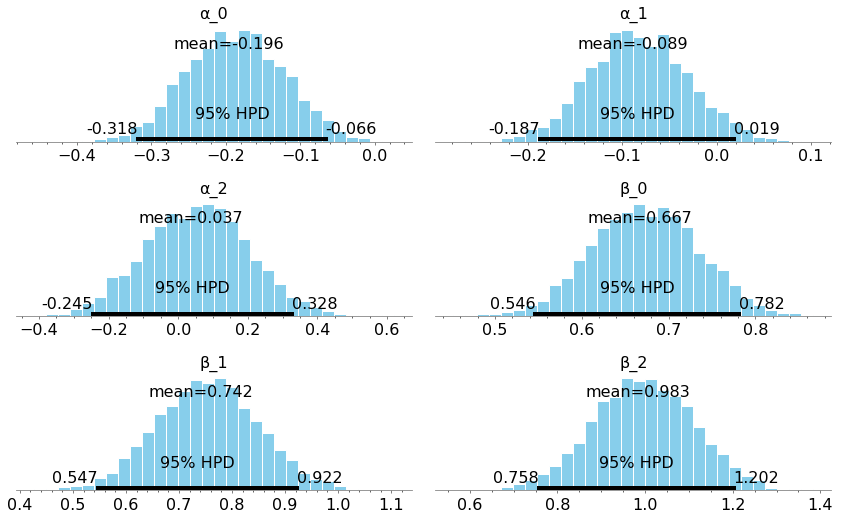

In [143]:
pm.plot_posterior(trace_unpooled_informative, varnames=['α', 'β']);

In [185]:
with pm.Model() as m_partially_pooled_informative:
    # prior on intercept
    hyp_α_mean = pm.Normal('hyp_α_mean', mu=0, sd=0.5)
    hyp_α_sd = pm.HalfCauchy('hyp_α_sd', beta=2.5)
    hyp_β_mean = pm.Normal('hyp_β_mean', mu=0, sd=0.2)
    hyp_β_sd = pm.HalfCauchy('hyp_β_sd', beta=2.5)
    # Here, I use an offsetting trick for easiser exploration of the parameter space
    α_offset = pm.Normal('α_offset', mu=0, sd=1, shape=n_blue_groups)
    β_offset = pm.Normal('β_offset', mu=0, sd=1, shape=n_blue_groups)
    # prior on 
    α = pm.Deterministic('α', hyp_α_mean + α_offset * hyp_α_sd) 
    # prior on slopes
    β = pm.Deterministic('β', hyp_β_mean + β_offset * hyp_β_sd)
    # prior on likelihood variance
    σ = pm.Exponential('σ', 1) 
    # likelihood's mean deterministic expression
    μ = α[X_train_s.maxBlueIdx.values,] + β[X_train_s.maxBlueIdx,] * X_train_s.green2MaxBlue_s.values 
    # likelihood
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) 

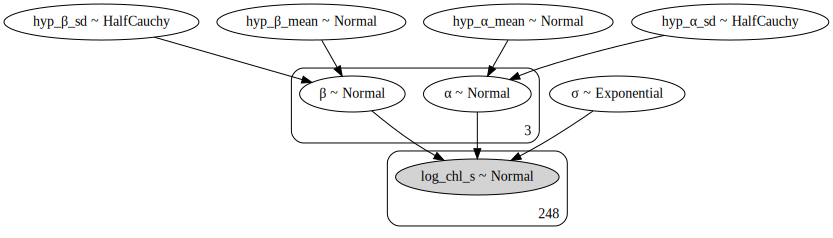

In [146]:
pm.model_to_graphviz(m_partially_pooled_informative)

In [ ]:
with m_partially_pooled_informative:
    trace_partially_pooled_informative = pm.sample(2000, tune=2000, chains=4,
                                                   nuts_kwargs=(dict(target_accept=0.95)
                                                               ))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/madhatter106/anaconda3/envs/busan_2019/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β_offset, α_offset, hyp_β_sd, hyp_β_mean, hyp_α_sd, hyp_α_mean]
Sampling 4 chains:  44%|████▍     | 7073/16000 [03:47<04:08, 35.91draws/s]

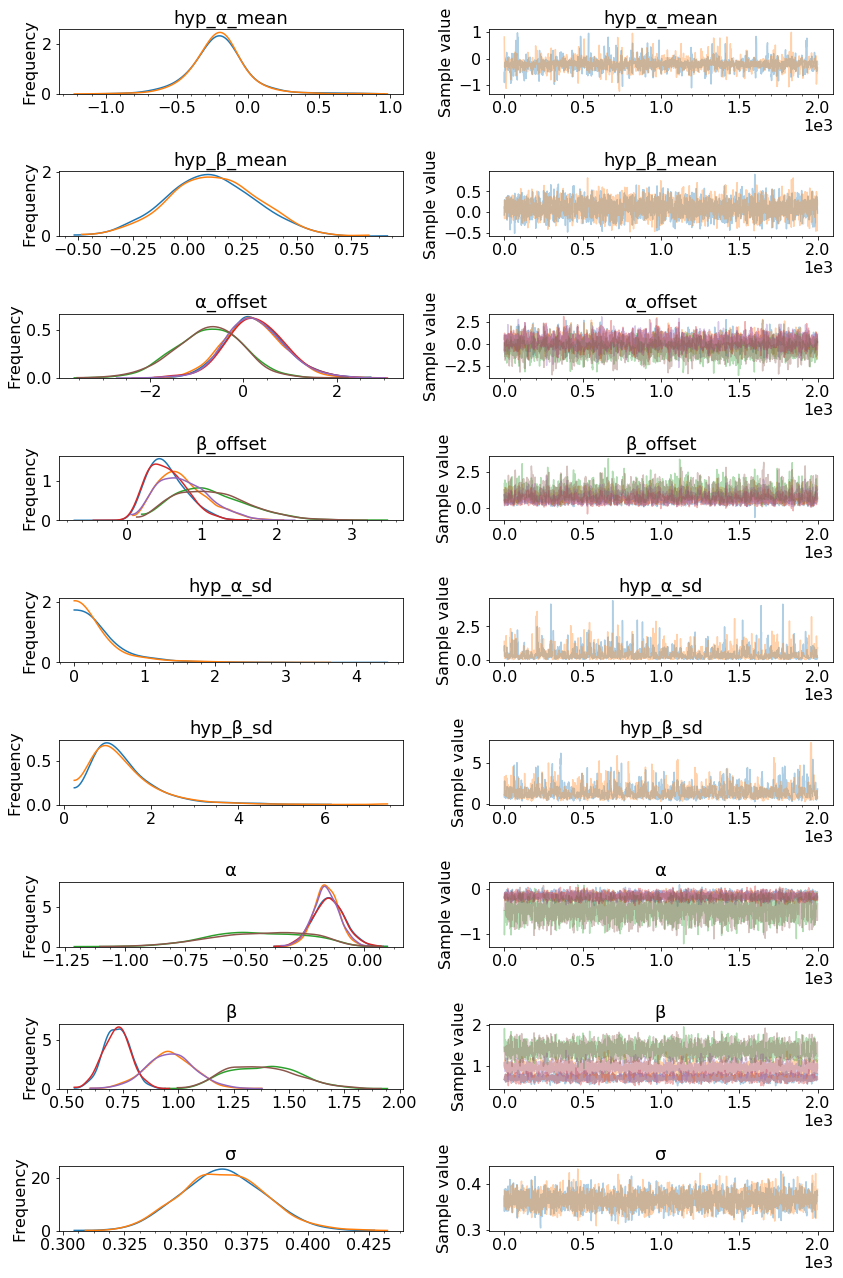

In [187]:
pm.traceplot(trace_partially_pooled_informative);

In [188]:
pm.summary(trace_partially_pooled_informative)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
hyp_α_mean,-0.204774,0.215621,0.005032,-0.653100,0.229905,1453.907009,0.999784
hyp_β_mean,0.110281,0.204927,0.004238,-0.283653,0.509156,2222.899091,1.001347
α_offset__0,0.266491,0.650242,0.014060,-0.948318,1.661560,1808.764406,0.999750
α_offset__1,0.220479,0.655348,0.014894,-1.003806,1.591743,1888.166277,1.000170
α_offset__2,-0.756083,0.754663,0.017348,-2.322636,0.647799,1989.356538,0.999761
β_offset__0,0.532837,0.257249,0.006973,0.094906,1.033464,1129.600024,0.999752
β_offset__1,0.752977,0.340652,0.009546,0.176888,1.431172,1035.063650,0.999987
β_offset__2,1.134935,0.498792,0.014373,0.305238,2.104616,1010.134404,0.999756
hyp_α_sd,0.391019,0.426270,0.011955,0.000007,1.191842,1284.310950,1.000335
hyp_β_sd,1.380719,0.792439,0.022331,0.318102,2.897500,951.057825,0.999815


/home/madhatter106/anaconda3/envs/busan_2019/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


(<Figure size 432x482.4 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd85bea8d68>],
       dtype=object))

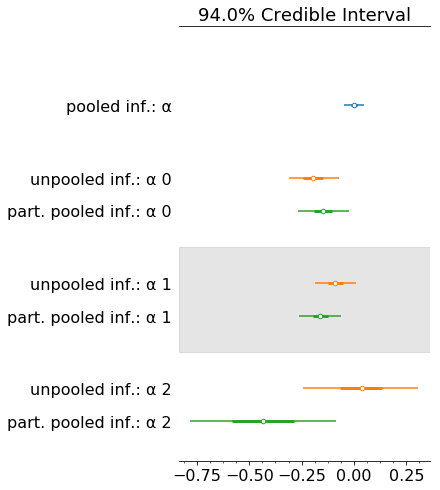

In [189]:
ar.plot_forest([trace_pooled_informative,
               trace_unpooled_informative,
               trace_partially_pooled_informative], 
              model_names= ['pooled inf.', 'unpooled inf.', 'part. pooled inf.'],
              var_names=['α'], combined=True)

GridSpec(1, 1)

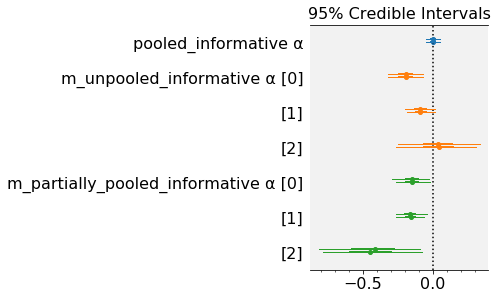

In [190]:
pm.forestplot(trace=[trace_pooled_informative,
               trace_unpooled_informative,
               trace_partially_pooled_informative], models=['pooled_informative',
                                                            'm_unpooled_informative',
                                                            'm_partially_pooled_informative'
                                                           ],
              varnames=['α'], rhat=False, colors=['C0', 'C1', 'C2'])

GridSpec(1, 1)

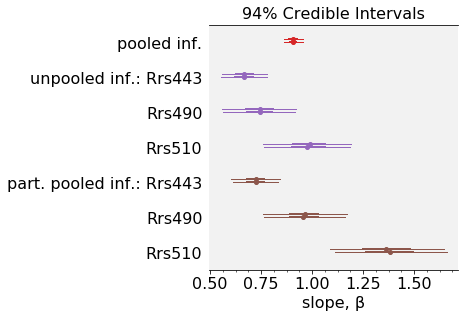

In [196]:
pm.forestplot(trace=[trace_pooled_informative,
                     trace_unpooled_informative, 
                     trace_partially_pooled_informative], 
              alpha=0.06, xtitle='slope, β',
              #models=['pooled inf.', 'unpooled inf.', 'part. pooled inf.'],
              varnames=['β'], rhat=False, colors=['C3', 'C4', 'C5'],
             ylabels=['pooled inf.', 'unpooled inf.: Rrs443', 'Rrs490', 'Rrs510', 
                      'part. pooled inf.: Rrs443', 'Rrs490', 'Rrs510'], 
         )

In [155]:
X_train_s.maxBlueID.value_counts()

Rrs443    110
Rrs490     76
Rrs510     62
Name: maxBlueID, dtype: int64

In [160]:
m_pooled_informative.name = 'pooled inf.'
m_partially_pooled_informative.name = 'part. pooled inf.'

In [194]:
pm.compare({m_pooled_informative: trace_pooled_informative,
               m_partially_pooled_informative: trace_partially_pooled_informative})

/home/madhatter106/anaconda3/envs/busan_2019/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


error: failed in converting 4th argument `xl' of _slsqp.slsqp to C/Fortran array

In [195]:
pm.compare({m_pooled_informative: trace_pooled_informative,
               m_partially_pooled_informative: trace_partially_pooled_informative}, ic='LOO')

error: failed in converting 4th argument `xl' of _slsqp.slsqp to C/Fortran array